# Tarea 3: PINNs, Redes Recurrentes y Transformers 

En esta Tarea Trabajaremos Con [Pytorch](https://pytorch.org/), una librería de Deep Learning de código abierto desarrollada por Facebook. Pytorch es una librería de Deep Learning que se basa en el concepto de [Tensores](https://pytorch.org/docs/stable/tensors.html), que son similares a los arreglos de Numpy, pero con la diferencia de que pueden ser utilizados en una GPU para acelerar los cálculos.

Se escogio Pytorch por sobre Tensorflow o Keras ya que tiene un paquete de [diferenciacion automatica](https://pytorch.org/docs/stable/autograd.html) que nos permite calcular derivadas de forma automatica, lo que nos permite implementar de forma sencilla los modelos de redes neuronales y sobre todo trabajar con PINNs y modificar pequeños detalles de forma sencilla en el lopp de entrenamiento como lo es aplicar custom losses, etc.

Dado que la ultima seccion del curso esta enfocado a trabajar con series temporales, todos los problemas en esta tarea de alguna u otra forma estan relacionados con series temporales o secuencias.

## Integrantes:

Tarea desarrollada por Grupo 02, conformado por:

* Nombre: Joaquín	García, Rol 201973087-8.
* Nombre: Gabriel	Díaz, Rol 201973095-9.
* Nombre: Bruno	Liberona, Rol 201973013-4.
* Nombre: Simón Appel, Rol 201973120-3.

# 1. Imports

In [1]:
#data
import numpy as np
import pandas  as pd

# torch
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Evaluation 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(123)

En esta tarea tenemos 2 Secciones obligatorias, la parte de Redes Recurrentes y la Parte de Transformers, pero como no hay desafio Kaggle se añadio una seccion extra sobre PINNS (Physics Informed Neural Networks) la cual es opcional y sirve como bonus para la nota final.

Dado que no hay desafio Kaggle se incentiva a ser creativos y modificar los codigos, esto tambien añadira un bonus para la tarea.

# Parte 2: Redes Recurrentes

En esta tarea no hay desafio kaggle, por lo que en esta seccion deberan utilizar su creatividad para resolver un problema de series temporales, utilizando redes recurrentes.

## 2.1 Cargar Datos

In [2]:
train_df = pd.read_csv('data/DailyClimate_Train.csv')
test_df = pd.read_csv('data/DailyClimate_test.csv')

## 2.2 EDA & data Viz

En esta seccion deberan realizar un analisis exploratorio de los datos, generar visualizaciones que les permitan entender mejor los datos con los que estan trabajando y sacar conclusiones de estos.

In [256]:
### Start code here ###
train_df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [257]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [258]:
print(train_df.describe())

          meantemp     humidity   wind_speed  meanpressure
count  1462.000000  1462.000000  1462.000000   1462.000000
mean     25.495521    60.771702     6.802209   1011.104548
std       7.348103    16.769652     4.561602    180.231668
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.580357
50%      27.714286    62.625000     6.221667   1008.563492
75%      31.305804    72.218750     9.238235   1014.944901
max      38.714286   100.000000    42.220000   7679.333333


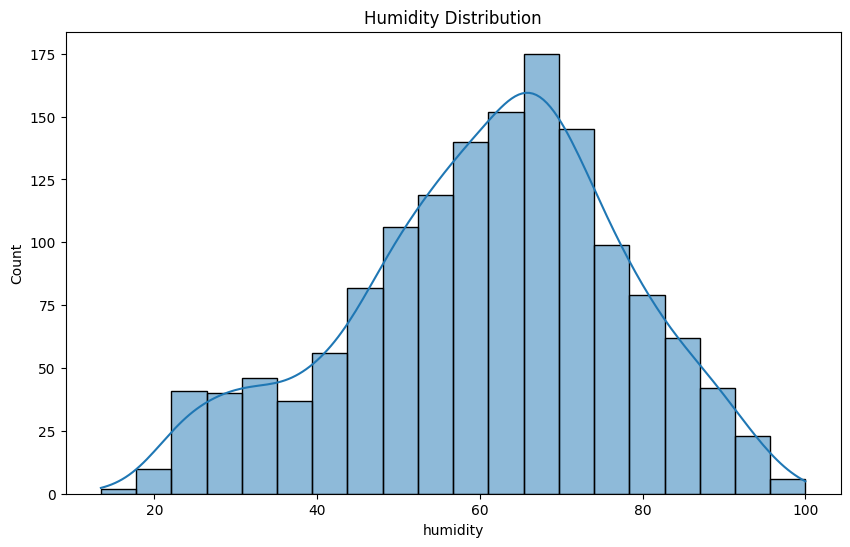

In [259]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['humidity'], bins=20, kde=True)
plt.title('Humidity Distribution')
plt.show()

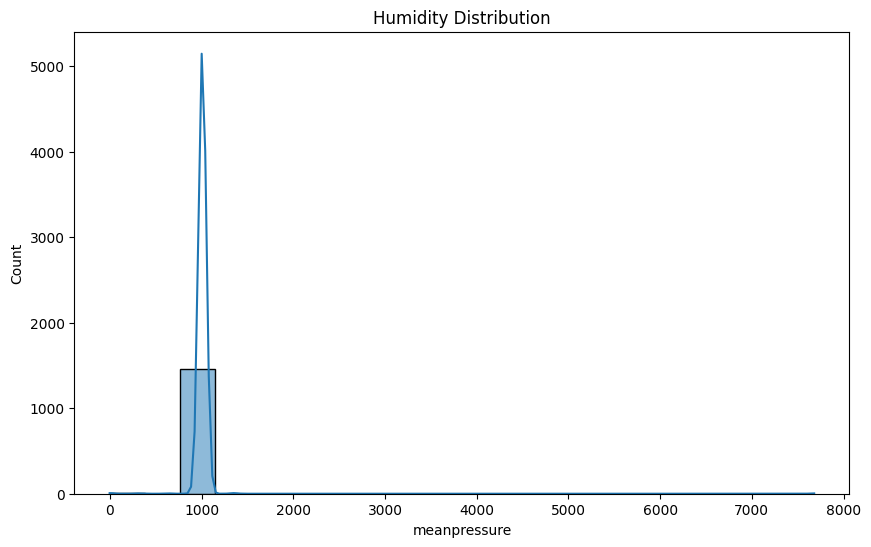

In [260]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['meanpressure'], bins=20, kde=True)
plt.title('Humidity Distribution')
plt.show()

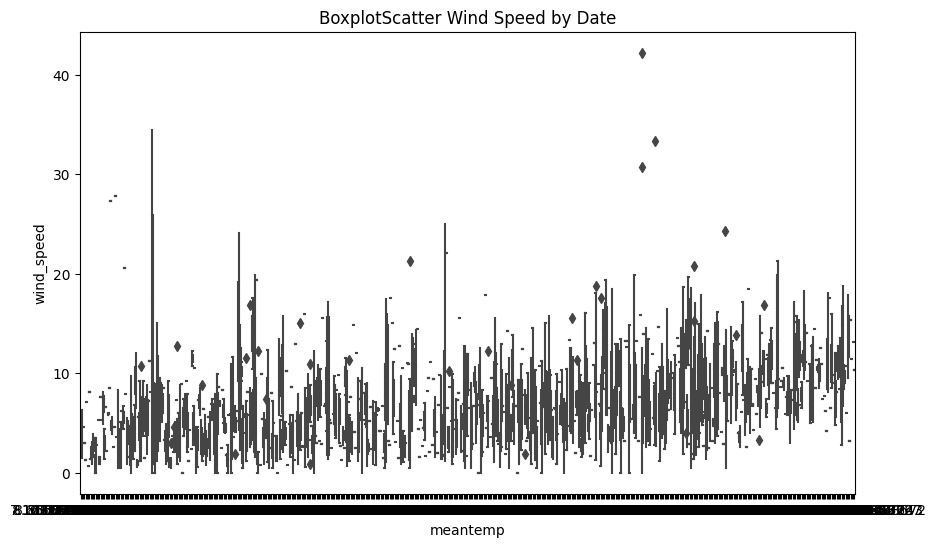

In [261]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='meantemp', y='wind_speed', data=train_df)
plt.title('BoxplotScatter Wind Speed by Date')
plt.show()

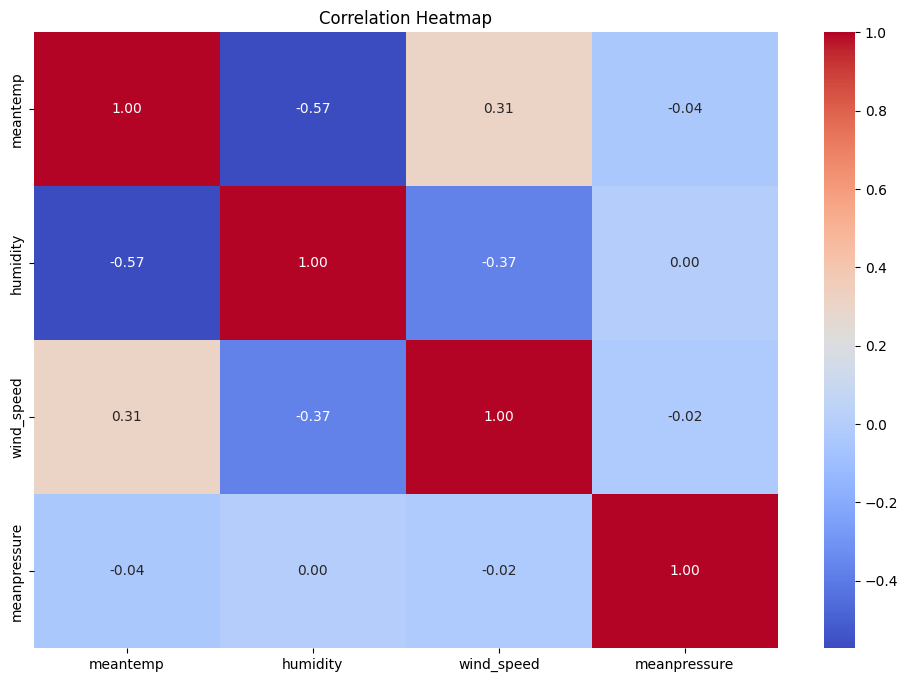

In [262]:
non_numeric_columns = ['date']

# Exclude non-numeric columns from the correlation matrix
numeric_columns = [col for col in train_df.columns if col not in non_numeric_columns]
correlation_matrix = train_df[numeric_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [263]:
fig = px.scatter(train_df, x='wind_speed', y='humidity', color='date')
fig.show()

In [264]:
fig = px.histogram(train_df, x='meantemp', color='date', marginal='box')
fig.show()

In [265]:
sample_df = train_df.copy()
sample_df['date_numeric'] = sample_df['date'].factorize()[0]


fig = px.scatter_3d(sample_df, x='wind_speed', y='humidity', z='meanpressure', color='date_numeric')
fig.show()

## 2.3 Preprocesamiento

En esta seccion deberan aplicar las transformaciones necesarias a los datos para poder entrenar su modelo, crear columnas, eliminar columnas, escalar los datos, etc.

In [272]:
train = train_df
test = test_df

In [273]:
threshold = 2000
train['meanpressure'] = train['meanpressure'].clip(upper=threshold)

### Start Code Here ###
minmax_scaler = MinMaxScaler()
feat_transform_minmax = ["humidity", "wind_speed", "meanpressure","meantemp"]

train[feat_transform_minmax] = minmax_scaler.fit_transform(train[feat_transform_minmax])
test[feat_transform_minmax] = minmax_scaler.fit_transform(test[feat_transform_minmax])

In [274]:
objective_col = 'meantemp' # columna objetivo
selected_cols = ['wind_speed', 'humidity', 'meanpressure']# lista de columnas seleccionadas para entrenar

In [275]:
# En este ejemplo nos quedamos solo con las columnas numericas, pero la idea es que en la lista anterior se incluyan las columnas que se quieran usar para entrenar el modelo, columnas nuevas que hayan creado o modificado en el preprocesamiento.
selected_cols = train.drop(columns=objective_col).select_dtypes(include='number').columns.tolist() #solo ejecutar a modo de ejemplo

In [276]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [277]:
# IMPORTANTE: agregamos la columna objetivo al final de la lista, deben asegurarse de que este al final para el correcto funcionamiento del codigo
selected_cols.append(objective_col) 
selected_cols

['humidity', 'wind_speed', 'meanpressure', 'meantemp']

In [278]:
tr_timeseries = train[selected_cols].values.astype('float32')
te_timeseries = test[selected_cols].values.astype('float32')

In [279]:
# concatenamos los dataframes para despues hacer las visualizaciones, No borrar ni modificar
new = pd.concat([train_df, test_df], axis=0).reset_index().drop('index', axis=1)
new_timeseries = new[selected_cols].values.astype('float32')
shape = new_timeseries.shape[1]

## 2.4 Dataset y DataLoader

In [280]:
def create_dataset(dataset, lookback, shape):
    """Funcion para crear los tensores de entrenamiento y test
    dataset: np.ndarray
    lookback: int (numero de dias a considerar o largo de la secuencia)
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[:,:shape-1][i:i+lookback]
        target = dataset[:, shape-1][i:i+lookback]
        X.append(feature)
        y.append(target)
    # Convierte las listas a np.ndarray antes de convertirlas en tensores
    X = np.array(X)
    y = np.array(y)
    return torch.tensor(X), torch.tensor(y)

In [281]:
lookback = 7 #consideraremos los ultimos 7 dias para predecir el dia siguiente

train, test = tr_timeseries, te_timeseries
X_train, y_train = create_dataset(train, lookback=lookback, shape=shape)
X_test, y_test = create_dataset(test, lookback=lookback, shape=shape)

In [282]:
loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size = 8, shuffle = True) #dataloader para entrenar los modelos de Pytorch

## 2.5 Modelo Recurrente

En esta seccion se implementa uan clase base para modelos recurrentes, pueden utilizar esta clase o pueden modificarla o crear una nueva clase si lo desean, recuerden que hay bonus por creatividad en esta tarea.

In [283]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, bidirectional, rnn_class):
        super().__init__()
        # Verificar que rnn_class es una de las clases de RNN permitidas
        if rnn_class not in [nn.LSTM, nn.GRU, nn.RNN]:
            raise ValueError("rnn_class must be nn.LSTM, nn.GRU, or nn.RNN")

        # Inicializar la capa recurrente con la clase pasada como parámetro
        self.rnn = rnn_class(input_size=input_size,
                             hidden_size=hidden_size,
                             num_layers=num_layers,
                             batch_first=True,
                             bidirectional=bidirectional)
        
        # Calcular la dimensión de salida de la capa recurrente
        # Es doble si es bidireccional
        factor = 2 if bidirectional else 1
        
        self.dropout = nn.Dropout(p=dropout)
        self.linear1 = nn.Linear(hidden_size * factor, 64)    
        self.linear2 = nn.Linear(64, 32)
        self.output_linear = nn.Linear(32, 1) # Output Size de 1, ya que queremos predecir un valor para la temperatura.
        
    def forward(self, x):
        # LSTM devuelve (output, (h_n, c_n)) mientras que GRU y RNN solo devuelve (output, h_n)
        x, _ = self.rnn(x)
        x = self.dropout(x)         # Aplicar dropout
        x = self.linear1(x)         # Aplicar linear1
        x = self.linear2(x)         # Aplicar linear2
        x = self.output_linear(x)   # Aplicar output_linear
        return x

## 2.6 Hiperparámetros

Aca pueden variar los hiperparametros de la red recurrente, pueden agregar mas si lo desean, para mas informacion sobre los optimizadores pueden revisar la documentacion de [pytorch Optim](https://pytorch.org/docs/stable/optim.html), y para mas informacion sobre los criterios de perdida pueden revisar la documentacion de [pytorch Loss](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [284]:
# Hiperparametros del modelo
input_size = shape-1 
hidden_size = 128
num_layers = 4
dropout = 0.3
bidirectional = True #puede ser True o False
layer_type = nn.RNN #puede ser nn.RNN, nn.LSTM o nn.GRU

# Modelo
model = RNNModel(input_size, hidden_size, num_layers, dropout, bidirectional, layer_type)

#optimizador
lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# loss func: MSE
loss_fn = nn.MSELoss()

## 2.7 Funciones de entrenamiento y evaluacion

En esta seccion se implementan funciones que nos ayudaran a entrenar y evaluar nuestro modelo, Pytorch no implementa metodos como .fit() por ende los tenemos que crear desde cero, al igual que antes sientanse libres de modificar o crear nuevas funciones, para mas informacion sobre el training loop pueden revisar la documentacion de [pytorch Custom Training](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html#custom-training-loop)

In [285]:
class CustomEarlyStopping:
    """
    Funcion para detener el entrenamiento cuando la loss de validacion no mejora
    """
    def __init__(self, patience=20, delta=0, verbose=False):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None
        self.best_y_pred = None
    
    def __call__(self, val_loss, model, X):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}, score: {self.best_score}')
    
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_state = model.state_dict()
            with torch.no_grad():
                self.best_y_pred = model(X)
            self.counter = 0

In [286]:
def train_model(model, optimizer, early_stopping):
    """
    Funcion para entrenar el modelo
    """
    best_score = None
    best_weights = None

    n_epochs = 200

    for epoch in range(n_epochs):
        model.train() # Entrenamiento
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)# Forward pass
            loss = loss_fn(y_pred, y_batch.unsqueeze(2)) # Compute loss
            optimizer.zero_grad()  # Zero gradients
            loss.backward()        # Backward pass
            optimizer.step()       # Update weights   


        model.eval() # Validacion
        with torch.no_grad():
            y_pred = model(X_train) 
            train_rmse = np.sqrt(loss_fn(y_pred, y_train.unsqueeze(2)))
            
            y_pred = model(X_test) 
            test_rmse = np.sqrt(loss_fn(y_pred, y_test.unsqueeze(2)))
            
            if best_score is None or test_rmse < best_score:
                best_score = test_rmse
                best_weights = model.state_dict()
            
            early_stopping(test_rmse, model, X_test)
            
            # Check if early stopping criterion is met
            if early_stopping.early_stop:
                print("Early stopping")
                break
                
        if epoch % 10 == 0:
            print('*'*10, 'Epoch: ', epoch, '\ train RMSE: ', train_rmse, '\ test RMSE', test_rmse)
    
    return model, best_weights

In [287]:
def get_preds(model, best_weights):
    """
    Funcion para obtener las predicciones y desnormalizarlas
    """
    # Usamos los mejores pesos para hacer las predicciones
    if best_weights is not None:
        model.load_state_dict(best_weights)
        
        # Calculamos las predicciones
        with torch.no_grad():
            y_pred_train = model(X_train).clone().detach().cpu().numpy()
            y_pred_test = model(X_test).clone().detach().cpu().numpy()

        # Modificamos las dimensiones de las predicciones para luego graficarlas
        with torch.no_grad():
            train_predictions = np.ones_like(new_timeseries) * np.nan
            train_predictions[lookback: len(train)] = y_pred_train[:,-1,:]
            
            test_predictions = np.ones_like(new_timeseries) * np.nan
            test_predictions[len(train)+lookback:len(new_timeseries)] = y_pred_test[:,-1,:]

        return train_predictions, test_predictions

In [288]:
def plot_predictions(train_predictions, test_predictions, shape):  
    """
    Funcion para graficar las predicciones
    """
    # plot
    plt.figure(figsize=(20,10))
    plt.plot(new_timeseries[:,shape-1], c='b', label = 'True')
    plt.plot(train_predictions[:,shape-1], c='r', label = 'Train')
    plt.plot(test_predictions[:,shape-1], c='g', label = 'Test')
    plt.legend()
    plt.show()

In [289]:
def plot_eval(test_predictions, shape):
    """
    Funcion para graficar las predicciones
    """

    eval_df = pd.concat([test_df['meantemp'].reset_index(),pd.Series(test_predictions[:,shape-1][len(train):].reshape(-1).tolist())],axis=1).drop('index',axis=1) #creamos un dataframe con las predicciones y los valores reales

    eval_df.columns = ['real_meantemp', 'pred_meantemp'] #renombramos las columnas

    rmse = np.sqrt(mean_squared_error(eval_df.iloc[7:]['real_meantemp'], eval_df.iloc[7:]['pred_meantemp'])) #calculamos el rmse

    print(f'RMSE: {rmse}')

    fig = go.Figure(data = [ 
        go.Scatter(x = eval_df.index, y = eval_df['real_meantemp'], mode='lines', name = "Actual"),
        go.Scatter(x = eval_df.index, y = eval_df['pred_meantemp'], mode='lines', name="Predicted"),
    ])

    fig.update_layout(
        font = dict(size=17, family="Franklin Gothic"),
        template = 'simple_white',
        title = 'Real & Predicted Temperature'
    )

    fig.show()

## 2.8 Entrenamiento

In [290]:
early_stopping = CustomEarlyStopping(patience=15, verbose=True)
model, model_best_weights = train_model(model, optimizer, early_stopping)

********** Epoch:  0 \ train RMSE:  tensor(0.1772) \ test RMSE tensor(0.3206)
EarlyStopping counter: 1 out of 15, score: -0.258503794670105
EarlyStopping counter: 2 out of 15, score: -0.258503794670105
EarlyStopping counter: 3 out of 15, score: -0.258503794670105
EarlyStopping counter: 4 out of 15, score: -0.258503794670105
EarlyStopping counter: 1 out of 15, score: -0.23859408497810364
EarlyStopping counter: 1 out of 15, score: -0.22350884974002838
EarlyStopping counter: 2 out of 15, score: -0.22350884974002838
********** Epoch:  10 \ train RMSE:  tensor(0.1788) \ test RMSE tensor(0.2664)
EarlyStopping counter: 3 out of 15, score: -0.22350884974002838
EarlyStopping counter: 4 out of 15, score: -0.22350884974002838
EarlyStopping counter: 5 out of 15, score: -0.22350884974002838
EarlyStopping counter: 1 out of 15, score: -0.18082372844219208
EarlyStopping counter: 2 out of 15, score: -0.18082372844219208
EarlyStopping counter: 3 out of 15, score: -0.18082372844219208
EarlyStopping count

In [291]:
train_predictions, test_predictions = get_preds(model, model_best_weights)

In [293]:
test_predictions

array([[       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       ...,
       [0.3810233 , 0.3810233 , 0.3810233 , 0.3810233 ],
       [0.3826295 , 0.3826295 , 0.3826295 , 0.3826295 ],
       [0.43816632, 0.43816632, 0.43816632, 0.43816632]], dtype=float32)

## 2.9 Evaluacion

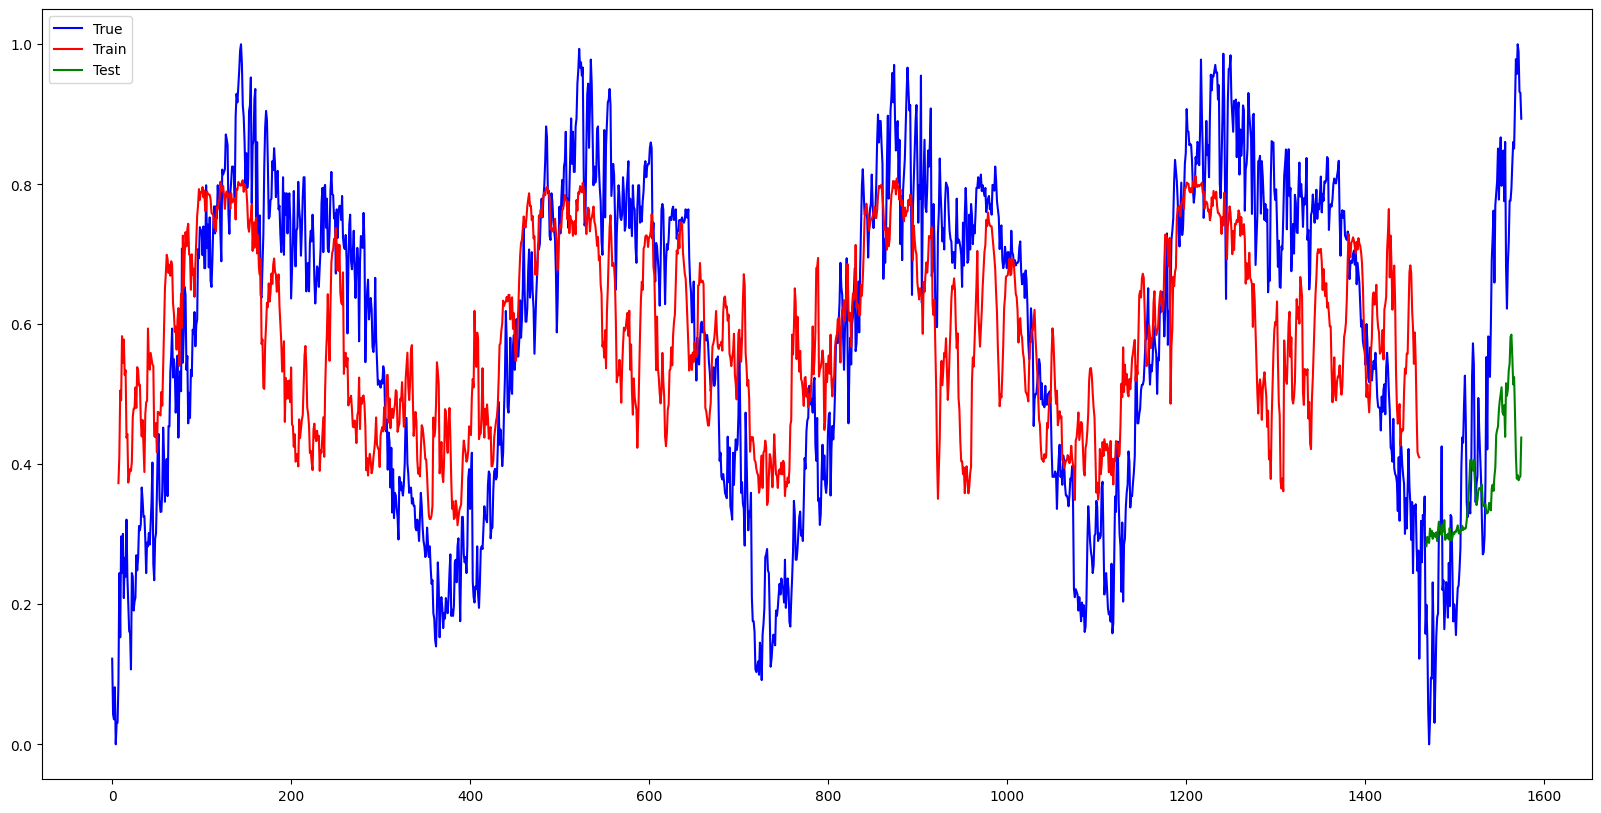

In [294]:
plot_predictions(train_predictions, test_predictions, 4)

In [296]:
plot_eval(test_predictions, 4)

RMSE: 0.24052018005654974


# Parte 3: Transformers

Para esta parte vamos a entrenar un transformer muy simple para que aprenda a generar texto como el del Quijote.

### 3.1 Cargar el dataset

In [2]:
with open('data/el_quijote.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1038397


In [4]:
# Visualizamos los primeros 1000 caracteres
print(text[:1000])

DON QUIJOTE DE LA MANCHA
Miguel de Cervantes Saavedra

PRIMERA PARTE
CAPÍTULO 1: Que trata de la condición y ejercicio del famoso hidalgo D. Quijote de la Mancha
En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor. Una olla de algo más vaca que carnero, salpicón las más noches, duelos y quebrantos los sábados, lentejas los viernes, algún palomino de añadidura los domingos, consumían las tres partes de su hacienda. El resto della concluían sayo de velarte, calzas de velludo para las fiestas con sus pantuflos de lo mismo, los días de entre semana se honraba con su vellori de lo más fino. Tenía en su casa una ama que pasaba de los cuarenta, y una sobrina que no llegaba a los veinte, y un mozo de campo y plaza, que así ensillaba el rocín como tomaba la podadera. Frisaba la edad de nuestro hidalgo con los cincuenta años, era de complexión recia, sec

### 3.2 Preprocesar el dataset

Vamos a crear un tokenizador muy simple que convierta el texto en una secuencia de números.

In [5]:
chars = list(set(text)) #obtener los caracteres unicos del texto
vocab_size = len(chars)
print('Caracteres unicos:',''.join(chars))
print('Largo del vocabulario:',vocab_size)

Caracteres unicos: –"¿9»FsA8pZSDP-.TIr!
)N4uXC3j(bz51eV70'̈d;l«2BitKvU:aq‘JxmG<¡’É“̀YLgyo]6hO[ ,?”QRWnMc̃fH
Largo del vocabulario: 89


### 3.3 Encoding y Decoding

Ahora que tenemos el tokenizador, vamos a crear una función que nos permita convertir el texto en una secuencia de números y viceversa.

In [6]:
# Mapeamos cada caracter a un entero
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: toma un string, devuelve una lista de enteros
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: toma una lista de enteros, devuelve un string

print(encode("Quijote de la Mancha"))
print(decode(encode("Quijote de la Mancha")))

[80, 24, 46, 28, 70, 47, 34, 76, 40, 34, 76, 42, 52, 76, 84, 52, 83, 85, 73, 52]
Quijote de la Mancha


**pregunta: Que otros tipos de tokenizaciones ademas de por caracteres existen y cuales serian las ventajas?**

* Tokenización por palabras: Divide el texto en palabras individuales. Cada palabra se convierte en un token, asignándole un número único. La ventaja de esta tokenización es que resulta más semántica al enfocarse en las palabras en vez de a cada caracter, logrando capturar de mejor manera el significado del texto.

* Tokenización por sub-palabras: Cada palabra del texto es dividida en sub-palabras, convirtiéndose estos últimos en los tokens. Este enfoque mejora la calidad de los datos al tokenizar, pues genera mayor representatividad con los tokens y el balanceo de los datos.

**Pregunta: ¿que otras tecnicas se utilizan antes de tokenizar en problemas de NLP?**

- Normalización: Consiste en convertir el texto a un formato estándar, como por ejemplo dejar todo en minúsculas, eliminar caracteres especiales o estandarizar su uso, etc. Esto se realiza con tal de reducir la aleatoriedad respecto a estos aspectos en los datos de entrada.

- Remoción de Stopwords: Se eliminan palabras comunes que no aportan demasiada información relevante al significado del texto, como "es", "el", "para", etc. Esto busca disminuir el tamaño de los datos de entrada y mejorar el enfoque en los datos realmente importantes.

- Stemming: Consite en eliminar la sección final de palabras relacionadas entre sí con tal de encontrar su "raíz". E.g. automático, automatizar, automatizable -> automati.

- Lemmatization: Consiste en eliminar la sección final de palabras con el mismo origen con tal de converger a este último. E.g. car, cars, cars', car's -> car.

### 3.4 Train y Val Split

In [7]:
# Vamos a Codificar el texto y llevarlo a un tensor de Pytorch
data = torch.tensor(encode(text), dtype=torch.long)

# Separamos en train y validation los datos para entrenar
n = int(len(data)*0.8)
train_data = data[:n]
val_data = data[n:]

print(train_data.shape, train_data.dtype)
print(train_data[:1000]) # los primeros 1000 caracteres del texto codificado

torch.Size([830717]) torch.int64
tensor([12, 74, 22, 76, 80, 50, 17, 55, 74, 16, 62, 76, 12, 62, 76, 67,  7, 76,
        84,  7, 22, 26, 88,  7, 20, 84, 46, 68, 24, 34, 42, 76, 40, 34, 76, 26,
        34, 18, 49, 52, 83, 47, 34,  6, 76, 11, 52, 52, 49, 34, 40, 18, 52, 20,
        20, 13, 81, 17, 84, 62, 81,  7, 76, 13,  7, 81, 16, 62, 20, 26,  7, 13,
        17, 63, 16, 50, 67, 74, 76, 33, 51, 76, 80, 24, 34, 76, 47, 18, 52, 47,
        52, 76, 40, 34, 76, 42, 52, 76, 85, 70, 83, 40, 46, 85, 46, 70, 63, 83,
        76, 69, 76, 34, 28, 34, 18, 85, 46, 85, 46, 70, 76, 40, 34, 42, 76, 87,
        52, 57, 70,  6, 70, 76, 73, 46, 40, 52, 42, 68, 70, 76, 12, 15, 76, 80,
        24, 46, 28, 70, 47, 34, 76, 40, 34, 76, 42, 52, 76, 84, 52, 83, 85, 73,
        52, 20, 62, 83, 76, 24, 83, 76, 42, 24, 68, 52, 18, 76, 40, 34, 76, 42,
        52, 76, 84, 52, 83, 85, 73, 52, 77, 76, 40, 34, 76, 85, 24, 69, 70, 76,
        83, 70, 57, 30, 18, 34, 76, 83, 70, 76, 53, 24, 46, 34, 18, 70, 76, 52,
       

### 3.5 Generando sequencias de texto

El transformer es una arquitectura de secuencias, por lo que necesitamos generar las secuencias de texto que vamos a utilizar para entrenar el modelo.

In [8]:
batch_size = 4 # cuantas secuencias de texto vamos a procesar en paralelo
block_size = 8 # definimos el largo de nuestra sequencia

def get_batch(split):
    # generamos un batch de datos
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [9]:
xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"cuando el input es {context} el target es: {target}")

inputs:
torch.Size([4, 8])
tensor([[52, 18, 53, 24, 34, 63,  6, 76],
        [76, 49, 34,  6, 47, 46, 40, 70],
        [52, 76, 57, 24, 28, 34, 18, 46],
        [85, 46, 34, 18, 47, 70, 76, 53]])
targets:
torch.Size([4, 8])
tensor([[18, 53, 24, 34, 63,  6, 76, 40],
        [49, 34,  6, 47, 46, 40, 70,  6],
        [76, 57, 24, 28, 34, 18, 46, 34],
        [46, 34, 18, 47, 70, 76, 53, 24]])
----
cuando el input es tensor([52]) el target es: 18
cuando el input es tensor([52, 18]) el target es: 53
cuando el input es tensor([52, 18, 53]) el target es: 24
cuando el input es tensor([52, 18, 53, 24]) el target es: 34
cuando el input es tensor([52, 18, 53, 24, 34]) el target es: 63
cuando el input es tensor([52, 18, 53, 24, 34, 63]) el target es: 6
cuando el input es tensor([52, 18, 53, 24, 34, 63,  6]) el target es: 76
cuando el input es tensor([52, 18, 53, 24, 34, 63,  6, 76]) el target es: 40
cuando el input es tensor([76]) el target es: 49
cuando el input es tensor([76, 49]) el target es: 

### 3.6 Creando el modelo

Vamos a crear un modelo naive que consiste en una capa de embedding, y una capa de salida que predice la siguiente palabra

In [10]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # cada token se representa como un vector de vocab_size dimensiones
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx y targets son (B, T) arrays de indices en el vocabulario
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            print(logits.shape)
            print(idx.shape)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :] 
            probs = F.softmax(logits, dim=-1) 
            idx_next = torch.multinomial(probs, num_samples=1) 
            idx = torch.cat((idx, idx_next), dim=1) 
        return idx

**Pregunta: Explique que hace la funcion Generate (indicar que hace cada linea de la funcion)**

- ```def generate(self, idx, max_new_tokens):```Se define la función con la secuencia de entrada y el número máximo de tokens como parámetros.
- ```for _ in range(max_new_tokens):```Este loop itera una cantidad de veces definida por 'max_new_tokens'. Es responsable por la generación de una secuencia de tokens, cada vez añadiendo un token nuevo a la secuencia de entrada.
- ```logits, loss = self(idx):```Llama al forward pass del modelo para obtener los 'logits' y la pérdida (loss).
- ```logits = logits[:, -1, :]:```Selecciona los logits que se encuentran en la última posición de la secuencia actual.
- ```probs = F.softmax(logits, dim=-1):```Los logits son pasados por una función softmax, a lo largo de la última dimensión (dim=-1). Con esto, los logits con transformados en probabilidades, permitiendo el muestreo del siguiente token.
- ```idx_next = torch.multinomial(probs, num_samples=1):```Esta línea muestra el índice del siguiente token de la distribución de probabilidad. 'multinomial' se utiliza para el muestreo de una distribución categórica.'num_samples=1' nos dice que solo queremos muestrear un token.
- ```idx = torch.cat((idx, idx_next), dim=1):```El índice de muestreo para el siguiente token es concatenado a la secuencia de entrada (idx) a lo largo de la dimensión de la secuencia (dim=1). Esto extiende la secuencia de entrada con el nuevo token generado.
- ```return idx:```Se retorna la secuencia de tokens generada.

In [11]:
# Hiperparametros
naive_model = BigramLanguageModel(vocab_size)
learning_rate = 0.001
optimizer = torch.optim.AdamW(naive_model.parameters(), lr=learning_rate)
#batch_size = 128
epochs = 20

En esta seccion deberan crear un loop de entrenamiento para esto pueden revisar la documentacion de [Pytorch](https://pytorch.org/docs/stable/index.html)

In [12]:
# Entrenamiento
for i in range(epochs):
    # obtenemos un batch de datos
    xb, yb = get_batch('train')

    # Obtenemos las predicciones del modelo y la loss
    logits, loss = naive_model(xb, targets=yb)
    
    # reseteamos el gradiente
    optimizer.zero_grad()

    # Backward Pass
    loss.backward()
    print("The value of loss is: ", loss)

    # Actualizamos los pesos
    optimizer.step()

    # Visualizamos el resultado cada 10 iteraciones
    if i % 10 == 0: 
        print(f"Epoch {i} | Loss {loss.item():.4f}")

torch.Size([4, 8, 89])
torch.Size([4, 8])
The value of loss is:  tensor(4.7851, grad_fn=<NllLossBackward0>)
Epoch 0 | Loss 4.7851
torch.Size([4, 8, 89])
torch.Size([4, 8])
The value of loss is:  tensor(4.8511, grad_fn=<NllLossBackward0>)
torch.Size([4, 8, 89])
torch.Size([4, 8])
The value of loss is:  tensor(5.2102, grad_fn=<NllLossBackward0>)
torch.Size([4, 8, 89])
torch.Size([4, 8])
The value of loss is:  tensor(4.8503, grad_fn=<NllLossBackward0>)
torch.Size([4, 8, 89])
torch.Size([4, 8])
The value of loss is:  tensor(4.9441, grad_fn=<NllLossBackward0>)
torch.Size([4, 8, 89])
torch.Size([4, 8])
The value of loss is:  tensor(4.9948, grad_fn=<NllLossBackward0>)
torch.Size([4, 8, 89])
torch.Size([4, 8])
The value of loss is:  tensor(4.9108, grad_fn=<NllLossBackward0>)
torch.Size([4, 8, 89])
torch.Size([4, 8])
The value of loss is:  tensor(4.8044, grad_fn=<NllLossBackward0>)
torch.Size([4, 8, 89])
torch.Size([4, 8])
The value of loss is:  tensor(4.9013, grad_fn=<NllLossBackward0>)
torch.

In [13]:
print('loss:', loss.item())
print(decode(naive_model.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

loss: 4.692987442016602
–T“L3B¿F83B6742DGaR’tp̃8AtGg8S!̀ “»”(j«?htKPil¡m';a»‘J“F"m)v̀Y3́̈iU.̀"ap"Wa«6vTt”RxXM”!<MvibelN,
Qd‘u


Como vemos el modelo no es capaaz de generar texto coherente, para esto vamos a utilizar un transformer.

### 3.7 Transformer

El transformer es una arquitectura de secuencias que utiliza atención para poder capturar dependencias de largo plazo, en esta seccion deberan completar las lineas de codigo faltantes, para esto pueden revisar el paper originar [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) y la documentacion de [Pytorch](https://pytorch.org/docs/stable/index.html)

In [14]:
n_embd = 512 # dimension de los embeddings
n_head = 8 # numero de cabezas de atencion
n_layer = 6 # numero de capas
dropout = 0.1 # dropout

In [15]:
class Head(nn.Module):
    """ cabezal de auto-atencion """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(head_size, head_size)
        self.query = nn.Linear(head_size, head_size)
        self.value = nn.Linear(head_size, head_size)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape

        k = self.key(x) # Calcula la matriz de pes= q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        softmax = F.softmax(wei, dim=-1)
        dropout = self.dropout(softmax)x = F.softmax(wei, dim=-

        # Calcula la ponderacion de los valores por los pesos atencionales
        v = self.value(x)
        out = torch.matmul(dropout, v)
        
        return out

SyntaxError: invalid syntax (3189908029.py, line 19)

**Pregunta: En sus propias palabras explique como funciona el mecanismo de auto-atencion**

Consiste en un mecanismo por el cual se asignan distintos pesos a las palabras en una secuencia al realizar el encoding o decoding. Este peso termina representando la importancia de cada una de las palabras.

Este mecanismo permite al modelo concentrarse en distintas partes del input al realizar predicciones.

In [ ]:
class MultiHeadAttention(nn.Module):
    """ Multiples cabezales de auto-atencion """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        head_outputs = [h(x) for h in self.heads]
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        
        return out

In [ ]:
class FeedFoward(nn.Module):
    """ Capa FeedForward """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 128),
            nn.ReLU(),  
            nn.Linear(128, n_embd)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class Block(nn.Module):
    """ Bloque de Transformer """

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head

        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        sa_output = self.sa(self.ln1(x))
        ffwd_output = self.ffwd(self.ln2(sa_output))

        x = x + 0.5 * sa_output + 0.5 * ffwd_output  # Adjust scaling factor as needed
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        
        return x

**Pregunta: Que parte del transformer estamos implementando?**

Se está implementando el mecanismo de MultiHeadAttention, la red FeedForward y un bloque básico Transformer.

* MultiHeadAttention ejecuta self-attention con múltiples heads, permitiendo que el modelo se enfoque en diferentes partes del input de manera simultánea.

* FeedFoward representa la red neuronal feed-forward completamente conectada en cuanto a la posición utilizada dentro de cada bloque del Transformer.

* Block integra estos componentes en un bloque único, aplicando normalización de capa y conexiones residuales alrededor de las capas de MultiHeadAttention y FeedForward, lo cual es característico de la arquitectura Transformer.

In [ ]:
# Ahora definimos el modelo completo con los bloques de Transformer
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :] # (B, C)
            probs = F.softmax(logits, dim=-1) # (B, C)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

**Bonus: Desde que salio el transformer se han publicado mejoras para esta arquitectura, si implementan alguna mejora con la referencia del paper en cuestion obtendran un bonus, se atreven?**

In [ ]:
model = BigramLanguageModel()
m = model.to(device)

# Parametros del modelo
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# Hiperparametros
lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
epochs = 200
eval_interval = 100
eval_iters = 200

3.073881 M parameters


In [ ]:
# Funcion de evaluar el modelo 
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
for i in range(epochs):
    # cada 100 iteraciones evaluamos el modelo
    if i % eval_interval == 0 or i == epochs - 1:
       losses = estimate_loss()
       print(f"step {i}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Obtenemos un batch de datos
    xb, yb = get_batch('train')

    # Obtener las predicciones del modelo y la loss
    logits, loss = model(xb, targets=yb)

    # reseteamos el gradiente
    optimizer.zero_grad()

    # Backward Pass
    loss.backward()

    # Actualizamos los pesos
    optimizer.step()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x512 and 64x64)

In [ ]:
# Generamos las predicciones
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


Eleil brados abía, éstaba acirdumas de me su pestí su que se ni pues, al forde una lariencabal curo; y alí se valvade que aalgántilo"
-Nespondió de su mandado de la recida. Perotres sagraso, y porque al los vida en el ningón con el las ha galar enfamala razon y las punto de acaseravan que respareo no de casas,tora de dé duda sin,  fue hasto de apenaba por todos Dioso Esten cama le soltión, y padros nos vuestro que sillestro y ellar de haced que que pe dijo Recho cual entura y la otras y Zoraño adelligatir due a barpes corrás as encamigarosu el malgas casilla osufa;, si comelsar compenio, y aún luello, a tantodo mate aun eruente, dondespecha elles niención mazo, selevatendo cierda; y tinienced mala ibonse de lo hecermas, las raza volvente por que él hubiero tierna, inteñoreso despeseju acomola dijo por adren del rálipa permadar El me las cuitros casasn de cuallabo señora, por ahedo dan tomanar alecigo, y estro; o su adía, venía quede ser engu, la sianque siemigeza, y

Ahora las predicciones ya tienen un poco de sentido, podemos seguir entrenando el modelo para que genere texto más coherente y pueden utilizar el modelo cambiando el archivo de input para generar texto de otros libros o de lo que ustedes quieran.

# Bonus: Armonic Oscillator (PINN)

## Simular un oscilador armónico

Vamos a utilizar una red neuronal con física incorporada (PINN por sus siglas en inglés) para resolver problemas relacionados con el **oscilador armónico amortiguado**:

<img src="img/oscillator.gif" width="500">

Nos interesa modelar el desplazamiento de la masa en un resorte (caja verde) a lo largo del tiempo.

Este es un problema canónico de la física, donde el desplazamiento, $u(t)$, del oscilador como función del tiempo puede ser descrito por la siguiente ecuación diferencial:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

donde $ m $ es la masa del oscilador, $ \mu $ es el coeficiente de fricción y $ k $ es la constante del resorte.

Nos centraremos en resolver el problema en el estado **subamortiguado**, es decir, donde la oscilación es lentamente amortiguada por la fricción (como se muestra en la animación arriba).

Matemáticamente, esto ocurre cuando:

$$
\delta < \omega_0~,~~~~~\mathrm{donde}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Además, consideramos las siguientes condiciones iniciales del sistema:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

Para este caso particular, la solución exacta es conocida y dada por:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{con}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$


### Definimos nuestra Red Neuronal

In [ ]:
class simple_ffn(nn.Module):
    "Definimos una red neuronal feed forward en PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.input = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.hidden = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.output = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.input(x)
        x = self.hidden(x)
        x = self.output(x)
        return x

*Pregunta: ¿Porque se utiliza Tanh como función de activación generalmente en las PINNs?*

###  Solucion Exacta

In [ ]:
def exact_solution(d, w0, t):
    "Define la solucion analitica del problema planteado"
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

### Puntos de entrenamiento

In [ ]:
# Definimos los puntos para la condicion de borde
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# Definimos los puntos del dominio del problema
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# parametros del problema
d, w0 = 2, 20
mu, k = 2*d, w0**2

# Solucion Exacta para comparar con el resultado de la red neuronal
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

### Hiperparámetros y Modelo

In [ ]:
epochs = 15001
pinn = simple_ffn(N_INPUT=1, N_OUTPUT=1, N_HIDDEN=32, N_LAYERS=3)
optim = torch.optim.Adam(pinn.parameters(),lr=1e-3)
lambda1, lambda2 = 1e-1, 1e-4

### Entrenamiento

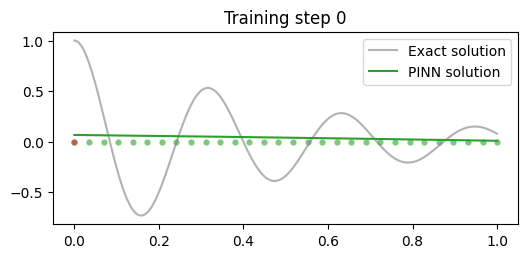

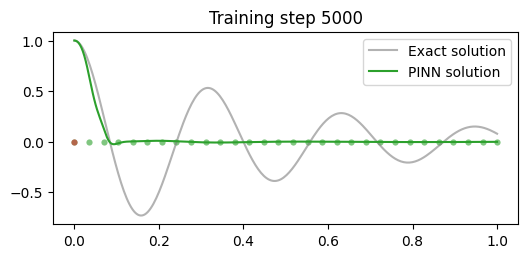

KeyboardInterrupt: 

In [ ]:
for i in range(15001):
    optim.zero_grad() # reseteamos el gradiente
    
    # Calculamos la perdida de la condicion de borde
    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0] # calculamos la derivada
    loss2 = (torch.squeeze(dudt) - 0)**2
    
    # Calculamos la perdida de la ecuacion diferencial
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0] # calculamos la derivada
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0] # calculamos la segunda derivada
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    # Calculamos la perdida total (Custom Loss)
    loss = loss1 + lambda1*loss2 + lambda2*loss3

    # Backward Pass
    loss.backward() 

    # Actualizamos los pesos
    optim.step()
    
    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0: 
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0], 
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0], 
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

## entrenar una PINN para invertir los parámetros subyacentes

La segunda tarea consiste en usar una PINN para **Estimar** parámetros.

Específicamente, nuestras entradas y salidas son:

- Entradas: observaciones con ruido del desplazamiento del oscilador
- Salidas: estimar $\mu$, el coeficiente de fricción

#### Enfoque

De manera similar a lo anterior, la PINN se entrena para aproximar directamente la solución a la ecuación diferencial, es decir

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

donde $\theta$ son los parámetros libres de la PINN.

La idea clave aquí es también tratar $\mu$ como un **parámetro aprendible** al entrenar la PINN, de modo que simulamos la solución e invertimos para este parámetro.

#### Función de pérdida

La PINN se entrena con una función de pérdida ligeramente diferente:

$$
\mathcal{L}(\theta, \mu)= \frac{1}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2 + \frac{\lambda}{M} \sum^{M}_{j} \left( u_{\mathrm{PINN}}(t_{j};\theta) - u_{\mathrm{obs}}(t_{j}) \right)^2
$$

#### Notas

Hay dos términos en la función de pérdida aquí. El primero es la **pérdida física**, formada de la misma manera que arriba, que asegura que la solución aprendida por la PINN es consistente con la física conocida.

El segundo término se llama **pérdida de datos**, y asegura que la solución aprendida por la PINN se ajuste a las observaciones de la solución (potencialmente con ruido) que están disponibles.

Nota, hemos eliminado los términos de pérdida de los bordes, ya que no los conocemos (es decir, solo se nos dan las mediciones observadas del sistema).

En esta configuración, los parámetros $\theta$ y $\mu$ de la PINN se aprenden **conjuntamente** durante la optimización.

Nuevamente, la autodiferenciación es nuestra amiga y nos permitirá definir fácilmente este problema.


### Puntos de Entrenamiento

True value of mu: 4


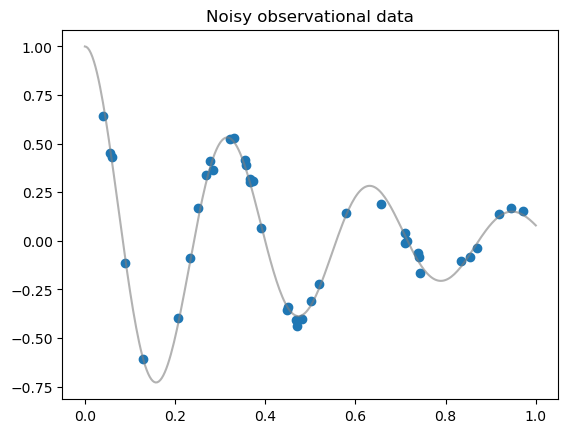

In [ ]:
# Creamos data con ruido
d, w0 = 2, 20
print(f"True value of mu: {2*d}")

# Definimos los puntos observacionales para que la red aprenda de los datos
t_obs = #TODO
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)

# definimos los puntos de entrenamiento sobre todo el dominio para la loss de la ecuacion diferencial
t_physics = #TODO

# parametros del problema
_, k = 2*d, w0**2

plt.figure()
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
t_test, u_exact = torch.linspace(0,1,300).view(-1,1), exact_solution(d, w0, t_test)
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.show()

### Hiperparámetros y Modelo

In [ ]:
# Creamos un parametro entrenable para mu
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
mus = []

epochs = #TODO
pinn = #TODO
optim = torch.optim.Adam(list(pinn.parameters())+[mu],lr=1e-3)
lambda1 = 1e4

### Entrenamiento

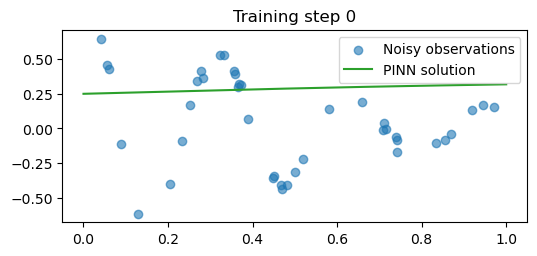

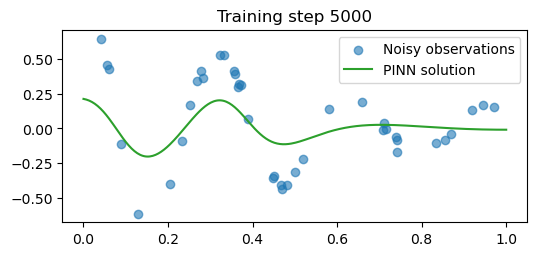

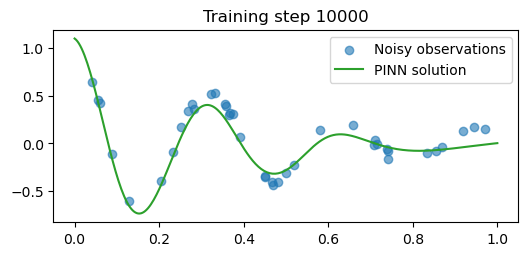

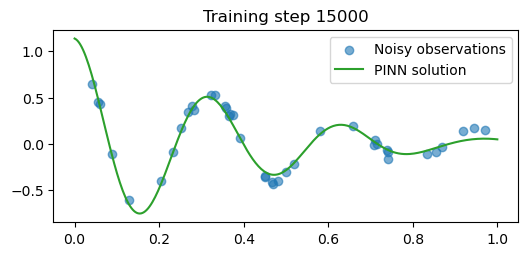

In [ ]:
for i in range(epochs):
    # reseteamos el gradiente
    #TODO
    
    # Calculamos la perdida de la ecuacion diferencial
    u = #TODO
    dudt = #TODO
    d2udt2 = #TODO
    loss1 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    # Calculamos la perdida en funcion de los datos
    u = #TODO
    loss2 = torch.mean((u - u_obs)**2)
    
    # Calculamos la perdida total (Custom Loss)
    loss = loss1 + lambda1*loss2

    # Backward Pass
    #TODO

    # Actualizamos los pesos
    #TODO
    
    # guardamos el valor de mu
    mus.append(mu.item())
    
    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0: 
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_obs[:,0], u_obs[:,0], label="Noisy observations", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

### Estimacion de $\mu$

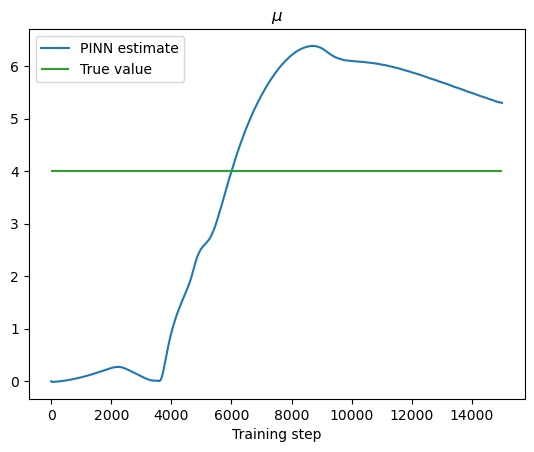

In [ ]:
plt.figure()
plt.title("$\mu$")
plt.plot(mus, label="PINN estimate")
plt.hlines(2*d, 0, len(mus), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

## cómo escala la PINN a oscilaciones de mayor frecuencia



La tarea final es investigar cómo escala la PINN a oscilaciones de mayor frecuencia y qué se puede hacer para mejorar su convergencia.

Específicamente, volvemos a simular la solución al oscilador armónico e incrementamos su frecuencia, $\omega_0$.


la PINN lucha para converger, incluso si el número de puntos de entrenamiento físico aumenta.

Este es un problema más difícil para la PINN de resolver, en parte debido al **sesgo espectral** de las redes neuronales, así como al hecho de que se requieren más puntos de entrenamiento.

#### Enfoque: formulación alternativa "ansatz"

Para acelerar la convergencia, una forma es **asumir algo** sobre la solución.

Por ejemplo, supongamos que sabemos por nuestra intuición física que la solución es de hecho sinusoidal.

Entonces, en lugar de tener la PINN aproximando directamente la solución a la ecuación diferencial, es decir

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

En su lugar, usamos la PINN como parte de un ansatz matemático de la solución, es decir

$$
\hat u(t; \theta, \alpha, \beta) = u_{\mathrm{PINN}}(t;\theta)  \sin (\alpha t + \beta) \approx u(t)~,
$$

donde $\alpha, \beta$ se tratan como parámetros adicionales aprendibles.

Comparando este ansatz con la solución exacta

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))
$$

Vemos que ahora la PINN solo necesita aprender la función exponencial, lo cual debería ser un problema mucho más fácil.

¡Una vez más, la autodiferenciación nos permite diferenciar fácilmente a través de este ansatz para entrenar la PINN!


### Puntos de Entrenamiento

In [ ]:
# Definimos los parametros A y B para la Ansatz
a = torch.nn.Parameter(70*torch.ones(1, requires_grad=True))
b = torch.nn.Parameter(torch.ones(1, requires_grad=True))

# Definimos los puntos de borde
t_boundary = #TODO

# Definimos los puntos de entrenamiento sobre todo el dominio para la loss de la ecuacion diferencial
t_physics = #TODO

# Parametros del problema
d, w0 = 2, 80 # las oscilaciones (w0) aumentaron
mu, k = 2*d, w0**2

# Solucion Exacta para comparar con el resultado de la red neuronal
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)


### Hiperparámetros y Modelo

In [ ]:
pinn = #TODO
optim = #TODO
lambda1, lambda2 = 1e-1, 1e-4

### Entrenamiento

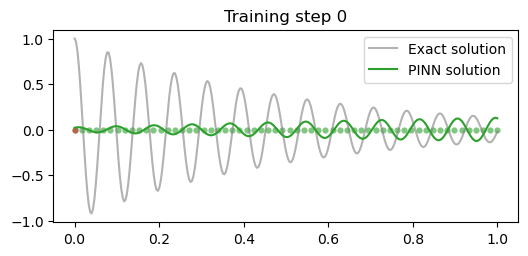

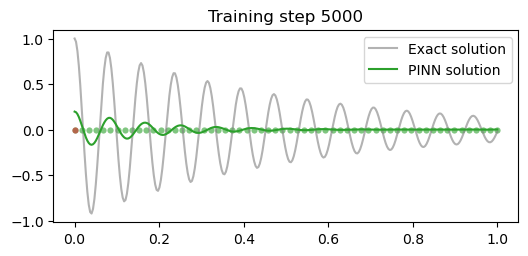

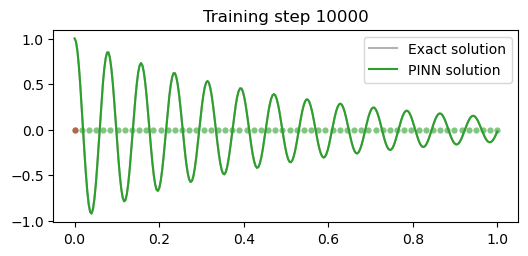

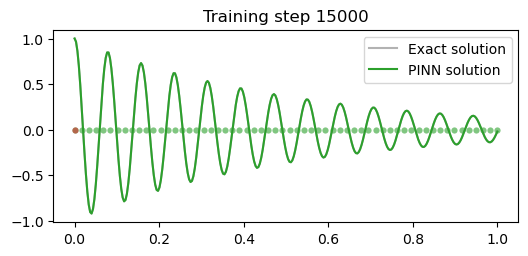

In [ ]:
for i in range(15001):
    # reseteamos el gradiente
    #TODO
    
    # Calculamos la perdida de la condicion de borde
    u = #TODO
    loss1 = #TODO
    dudt = #TODO
    loss2 = #TODO
    
    # Calculamos la perdida de la ecuacion diferencial
    u = #TODO
    dudt = #TODO
    d2udt2 = #TODO
    loss3 = #TODO
    
    # Calculamos la perdida total (Custom Loss)
    loss = loss1 + lambda1*loss2 + lambda2*loss3

    # Backward Pass
    #TODO

    # Actualizamos los pesos
    #TODO
    
    # Visualizamos el resultado cada 5000 iteraciones
    if i % 5000 == 0: 
        u = (pinn(t_test)*torch.sin(a*t_test+b)).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0], 
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0], 
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()